In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, zero_one_loss, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt

# Evidence

This version of the evidence is all the work I did before implementing Pipeline. Therefore, it uses different techniques for one-hot encoding/feature selection etc and produces different results. It is also not compatible with many of the later models I made. 

# Data Cleaning

Before we can make any models, we need to sort out our data to be how the classifier wants it. First, we see that some of the features are of type object, and therefore need changing to a quantitative value by one hot encoding. We also need to either remove or impute NaN values - I can see below that only 4.23% of rows in our training dataset and 2.74% of rows in the testing data have NaN values, so I decided it would be better to just remove these values for the sake of data integrity.

Next, we seperate the label 'stroke' from the features and seperate out our X and y for our models. Also note here I've removed the column 'id' as I know this is a randomly assigned value and will cause overfitting/noise. 

In [2]:
training_dataset = pd.read_csv('stroke_training_dataset_copy.csv')
testing_dataset = pd.read_csv('stroke_testing_dataset_copy.csv')

training_dataset.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [3]:
def transform_dataset(df):
    df['gender'], genders = pd.factorize(df['gender'])
    df['ever_married'], evermarried = pd.factorize(df['ever_married'])
    df['work_type'], worktype = pd.factorize(df['work_type'])
    df['smoking_status'], smokingstatus = pd.factorize(df['smoking_status'])
    df['Residence_type'], residencetype = pd.factorize(df['Residence_type'])

transform_dataset(training_dataset)
transform_dataset(testing_dataset)

training_dataset.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,51676,1,61.0,0,0,0,1,1,202.21,NaN,1,1
2,31112,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,60182,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1665,1,79.0,1,0,0,1,1,174.12,24.0,1,1
5,53882,0,74.0,1,1,0,0,1,70.09,27.4,1,1
6,10434,1,69.0,0,0,1,0,0,94.39,22.8,1,1
7,27419,1,59.0,0,0,0,0,1,76.15,NaN,3,1
8,60491,1,78.0,0,0,0,0,0,58.57,24.2,3,1
9,12109,1,81.0,1,0,0,0,1,80.43,29.7,1,1


In [4]:
print("% NaN rows in training data: ", 100 * (1 - training_dataset.dropna().shape[0] / training_dataset.shape[0]))
print("% NaN rows in testing data: ", 100 * (1 - testing_dataset.dropna().shape[0] / testing_dataset.shape[0]))

training_dataset = training_dataset.dropna()
testing_dataset = testing_dataset.dropna()

X_train = training_dataset.drop(['stroke', 'id'], axis=1)
y_train = training_dataset['stroke']

X_test = testing_dataset.drop(['stroke', 'id'], axis=1)
y_test = testing_dataset['stroke']

feature_names = list(X_train.columns)
print("\nFeatures:")
print(feature_names)

% NaN rows in training data:  4.231898238747556
% NaN rows in testing data:  2.73972602739726

Features:
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']


# Decision Trees

Before we move onto building a Random Forest, I am going to build a single Decision Tree model for comparison and to develop my understanding of what happens behind the Random Forest. Note that here I have set a seed of 42 so that we get the same results each time.

[Text(0.4582589949449896, 0.9722222222222222, 'age <= 66.5\ngini = 0.079\nsamples = 3915\nvalue = [3753, 162]'),
 Text(0.16358162355040143, 0.9166666666666666, 'age <= 44.5\ngini = 0.037\nsamples = 3252\nvalue = [3191, 61]'),
 Text(0.030924769550996135, 0.8611111111111112, 'avg_glucose_level <= 58.14\ngini = 0.005\nsamples = 1992\nvalue = [1987, 5]'),
 Text(0.014272970561998216, 0.8055555555555556, 'avg_glucose_level <= 58.06\ngini = 0.067\nsamples = 58\nvalue = [56, 2]'),
 Text(0.00951531370799881, 0.75, 'avg_glucose_level <= 57.925\ngini = 0.034\nsamples = 57\nvalue = [56, 1]'),
 Text(0.004757656853999405, 0.6944444444444444, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(0.014272970561998216, 0.6944444444444444, 'avg_glucose_level <= 57.935\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.00951531370799881, 0.6388888888888888, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.01903062741599762, 0.6388888888888888, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.01903

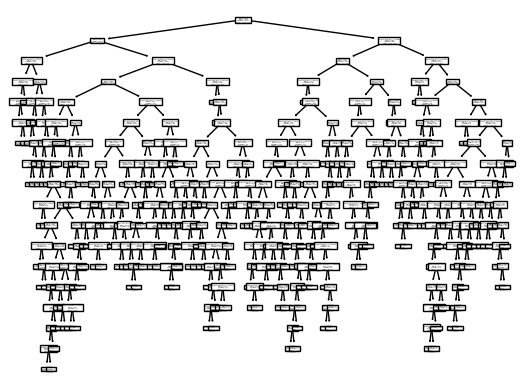

In [5]:
tree_model = DecisionTreeClassifier(criterion='gini',
                             max_depth=None, 
                             random_state=42)

tree_model.fit(X_train, y_train)
y_pred_dt = tree_model.predict(X_test)
error_dt = zero_one_loss(y_test,y_pred_dt) 
plot_tree(tree_model, feature_names = feature_names)

I notice that the tree seems to be overfitting quite a lot, which is common in decision trees. I will come back to this later under Model Refinement.
First, I am going to model the same tree with smaller max-depth so we can really see what's going on here in regards to the Gini Index and the splitting.

[Text(0.5, 0.8333333333333334, 'age <= 66.5\ngini = 0.079\nsamples = 3915\nvalue = [3753, 162]'),
 Text(0.25, 0.5, 'age <= 44.5\ngini = 0.037\nsamples = 3252\nvalue = [3191, 61]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.005\nsamples = 1992\nvalue = [1987, 5]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.085\nsamples = 1260\nvalue = [1204, 56]'),
 Text(0.75, 0.5, 'avg_glucose_level <= 126.84\ngini = 0.258\nsamples = 663\nvalue = [562, 101]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.214\nsamples = 452\nvalue = [397, 55]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.341\nsamples = 211\nvalue = [165, 46]')]

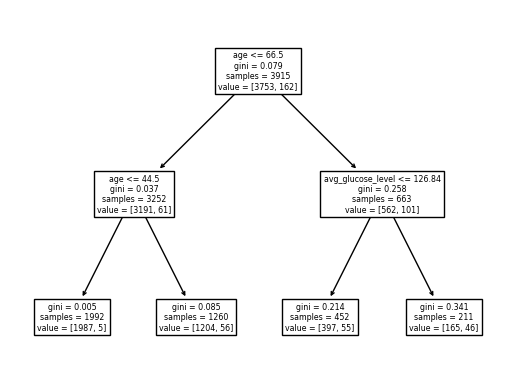

In [6]:
reduced_tree = DecisionTreeClassifier(criterion='gini',
                             max_depth=2,
                             random_state=42)
reduced_tree.fit(X_train, y_train)
plot_tree(reduced_tree, feature_names = feature_names)

# Random Forests
Now we can move onto the main model - the Random Forest. For my baseline model, I'm using 500 trees. In this section, I am exploring the difference in errors between Random Forests and Decision Trees, and how this error decreases as number of trees increases.

In [7]:
# For evidence

clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500)
clf.fit(X_train, y_train)

y_pred_rf = clf.predict(X_test)
error_rf = zero_one_loss(y_test, y_pred_rf) 

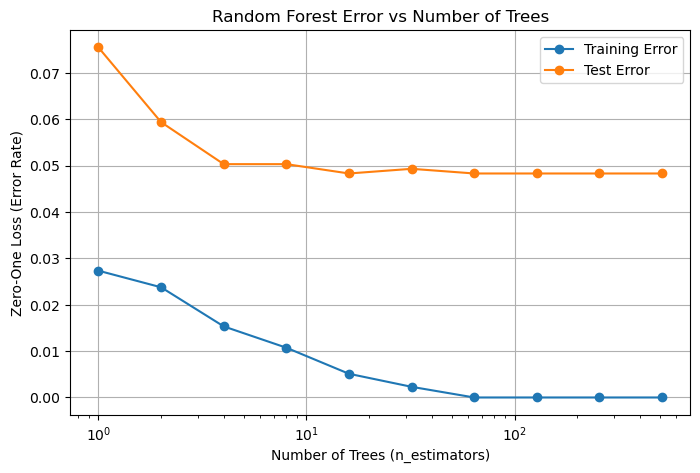

In [8]:
# For evidence

ntree_values = [2 ** i for i in range(10)]
training_errors = []
test_errors = []

for ntrees in ntree_values:
    tmpcf = RandomForestClassifier(n_estimators = ntrees)
    tmp_trained_model= tmpcf.fit(X_train, y_train)
    tmp_y_pred = tmp_trained_model.predict(X_test)
    tmp_y_pred_train = tmp_trained_model.predict(X_train)
    tmp_test_error = zero_one_loss(y_test,tmp_y_pred)
    test_errors.append(round(tmp_test_error, 6))
    tmp_train_error = zero_one_loss(y_train,tmp_y_pred_train)
    training_errors.append(round(tmp_train_error, 6))

plt.figure(figsize=(8, 5))
plt.plot(ntree_values, training_errors, 'o-', label='Training Error')
plt.plot(ntree_values, test_errors, 'o-', label='Test Error')
plt.xscale('log')
plt.title('Random Forest Error vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Zero-One Loss (Error Rate)')
plt.legend()
plt.grid(True)
plt.show()

## Cross Validation on Baseline Random Forest
Let's use cross validation to test how our random forest model reacts to different datasets. I use stratified sampling to make sure each 'test' data has an equal proportion of stroke and non-stroke cases.

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='average_precision')

print("Cross-validation AUPRC scores for each fold:", np.round(cv_scores, 4))
print("Mean AUPRC across folds:", round(np.mean(cv_scores), 4))
print("Standard deviation:", round(np.std(cv_scores), 4))

Cross-validation AUPRC scores for each fold: [0.1522 0.1452 0.1203 0.1294 0.1534]
Mean AUPRC across folds: 0.1401
Standard deviation: 0.0131


Each sample has a consistent AUPRC (0.13 ± 0.02), meaning the RF model is stable ie. performs the same on different data samples, so we can expect roughly the same when we find the performance metric (precision recall) using our real test data. 

## Baseline Random Forest Evaluation

Due to the imbalance in (a very small proportion of positive cases) and context of our data (it's more important to correctly identify positive cases as these are people likely to have a stroke) we chose Precision-Recall as our performance metric. First, I am going to find the proportion of positive cases in our test data, as this is the baseline for the AU-PRC. ie If we just guessed randomly each time, we would be correct this proportion of the time, so a value any higher than this indicates the model's success.

In [10]:
print("Proportion of stroke cases in dataset:", round(np.mean(y_test), 4))

def evaluate_pr(model, X, y):
    y_proba = model.predict_proba(X)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_proba)
    auprc = auc(recalls, precisions)

    print("Area Under Precision-Recall Curve (AUPRC):", round(auprc, 4))

    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()

def evaluate_pr_cross_val(model, X, y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()

    fold = 1
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_proba = model.predict_proba(X_val_fold)[:, 1]

        precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba)
        auprc = auc(recalls, precisions)
        scores.append(auprc)

        ax = axes[i]
        ax.plot(recalls, precisions)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Fold {fold} — AUPRC: {round(auprc, 4)}')
        ax.grid(True)

        fold += 1

    for j in range(fold - 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    print(f"\nMean AUPRC across {n_splits} folds: {round(np.mean(scores), 4)}")
    return np.mean(scores), scores


Proportion of stroke cases in dataset: 0.0473


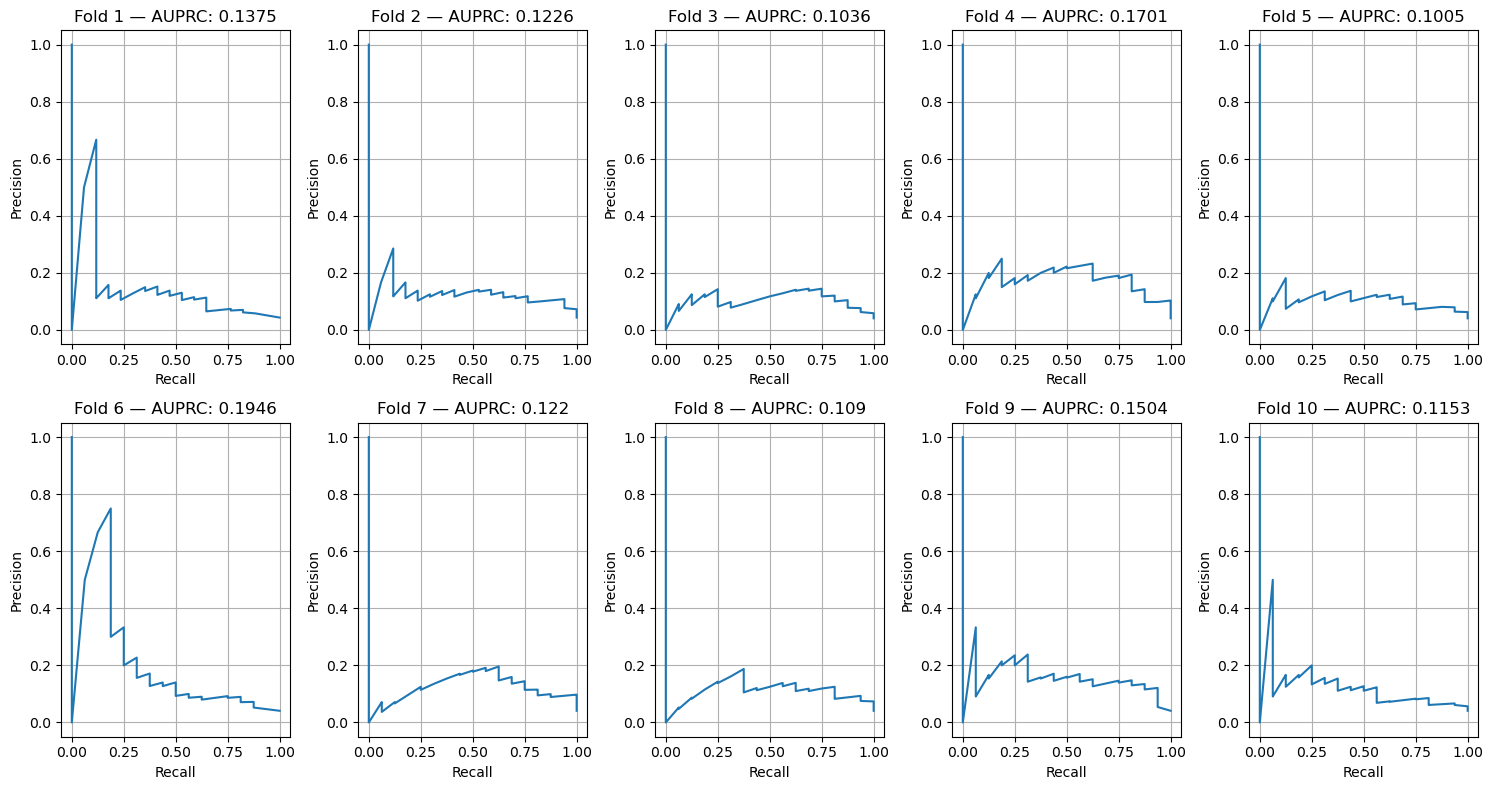


Mean AUPRC across 10 folds: 0.1326


In [11]:
mean_auprc, all_scores = evaluate_pr_cross_val(clf, X_train, y_train, 10)

# Model Refinement
There are many ways we can use our training data to 'train' our model in hopes of a better performance metric. Let's try a few.

## Feature Selection
The first thing to consider to refine the model is whether feature selection could help. First, let's find the importance of each feature based on the training data only, then remove unselected features from all of the data, and see how our performance metric changes.

I did some tampering with the importance threshold here - I found no matter how low I put the threshold the removal of any features negatively impacted the mean AUPRC score, so can conclude that all features have an importance.

                   importance
avg_glucose_level    0.286301
bmi                  0.238582
age                  0.223776
smoking_status       0.064588
work_type            0.048500
Residence_type       0.034537
gender               0.032461
hypertension         0.027079
heart_disease        0.025510
ever_married         0.018666

Selected features:
Index(['avg_glucose_level', 'bmi', 'age', 'smoking_status', 'work_type',
       'Residence_type', 'gender', 'hypertension', 'heart_disease'],
      dtype='object')


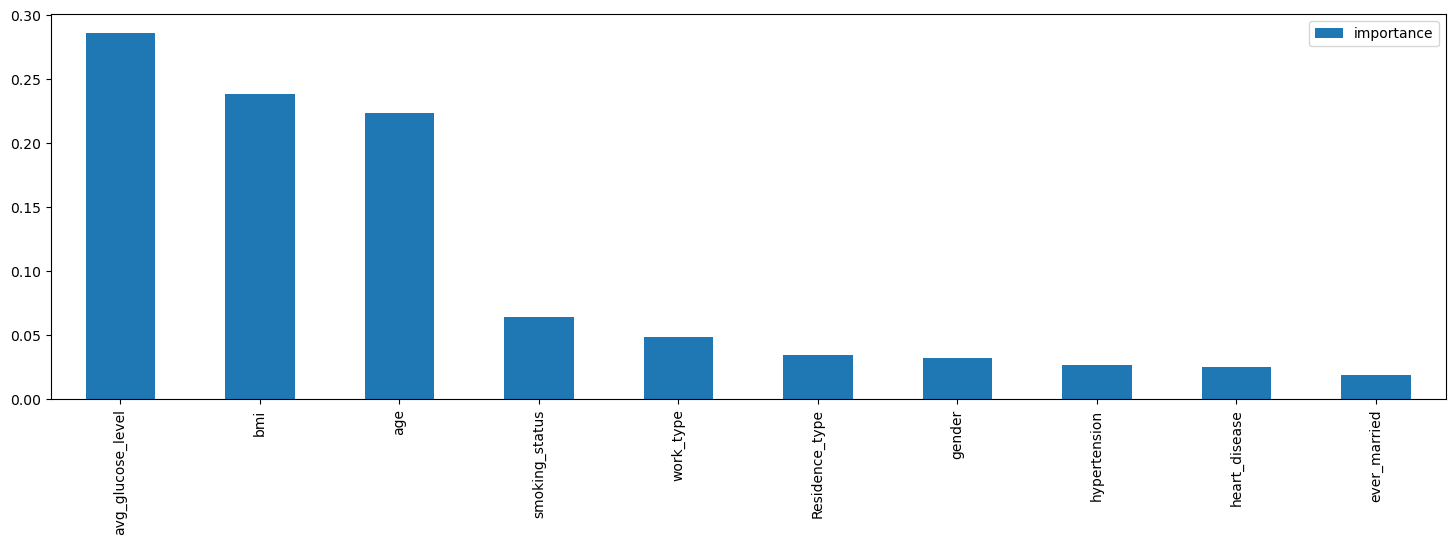

In [12]:
feature_importances = pd.DataFrame(
    clf.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

print(feature_importances)

feature_importances.nlargest(10, 'importance').plot(kind='bar', figsize=(18, 5))
importance_threshold = 0.025
selected_features = feature_importances[feature_importances['importance'] >= importance_threshold].index

print("\nSelected features:")
print(selected_features)

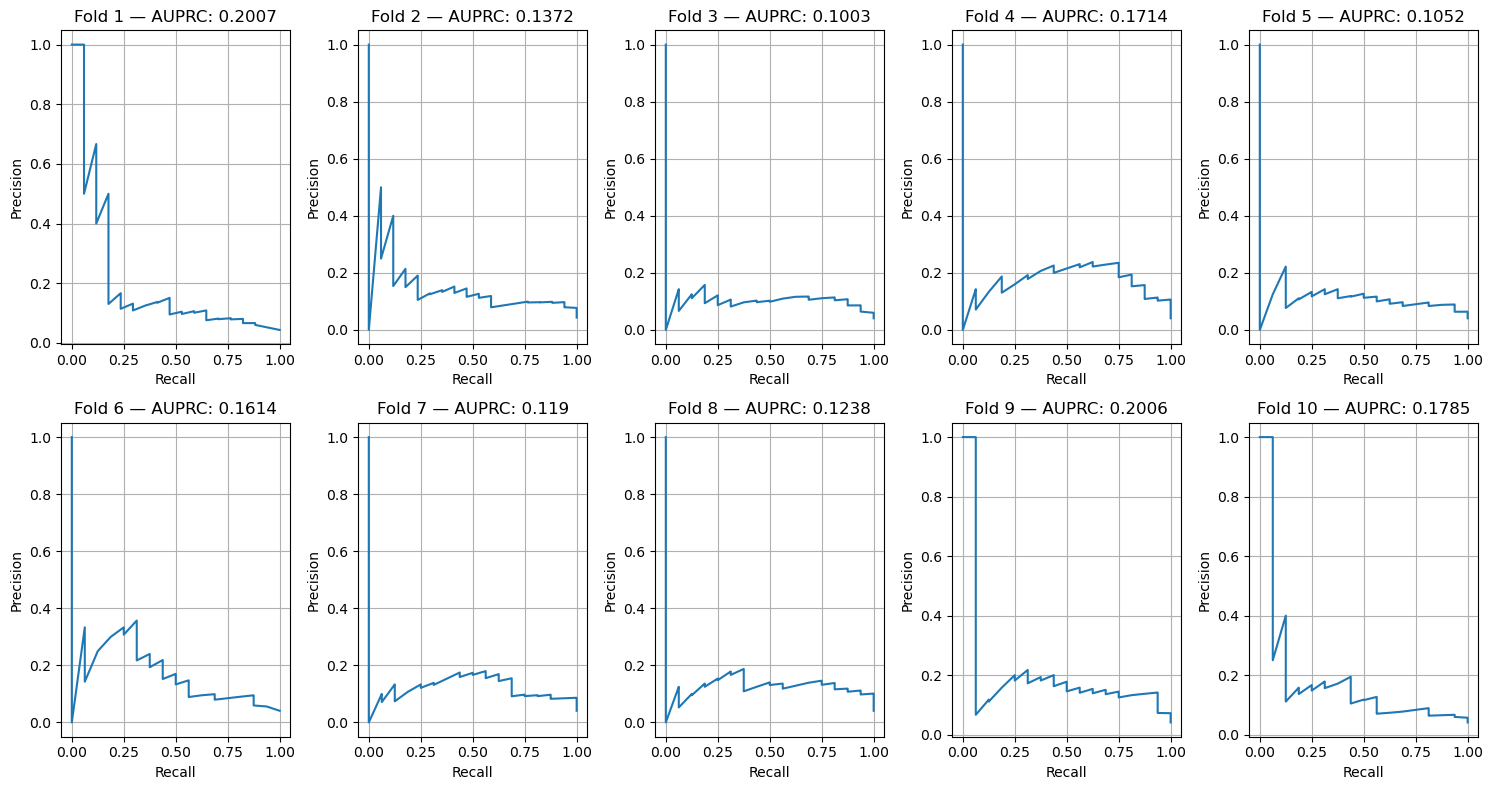


Mean AUPRC across 10 folds: 0.1498


In [13]:
X_train_after_feature_selection = X_train[selected_features]
X_test_after_feature_selection = X_test[selected_features]

rf_model_after_feature_selection = clf.fit(X_train_after_feature_selection, y_train)

mean_auprc, all_scores = evaluate_pr_cross_val(rf_model_after_feature_selection, X_train_after_feature_selection, y_train, 10)

## Hyperparameter Tuning
The performance of our random forest model heavily depends on having the optimal combination of hyperparameters for the data selected. Luckily, sklearn has a feature called GridSearchCV which allows us to try many combinations of these parameters and selects the optimal one. The balance being struck between many of these parameters such as 'max_depth' and 'min_samples_leaf' is between overfitting and generalisation. Note we are using 'average_precision' as our scorer since we are most interested in our precision-recall curve and metric. 

Let's see how it affects our Precision-Recall score. We are running this on a new Random Forest model without the feature selection done. Is it more or less effective than feature selection?

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='average_precision',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


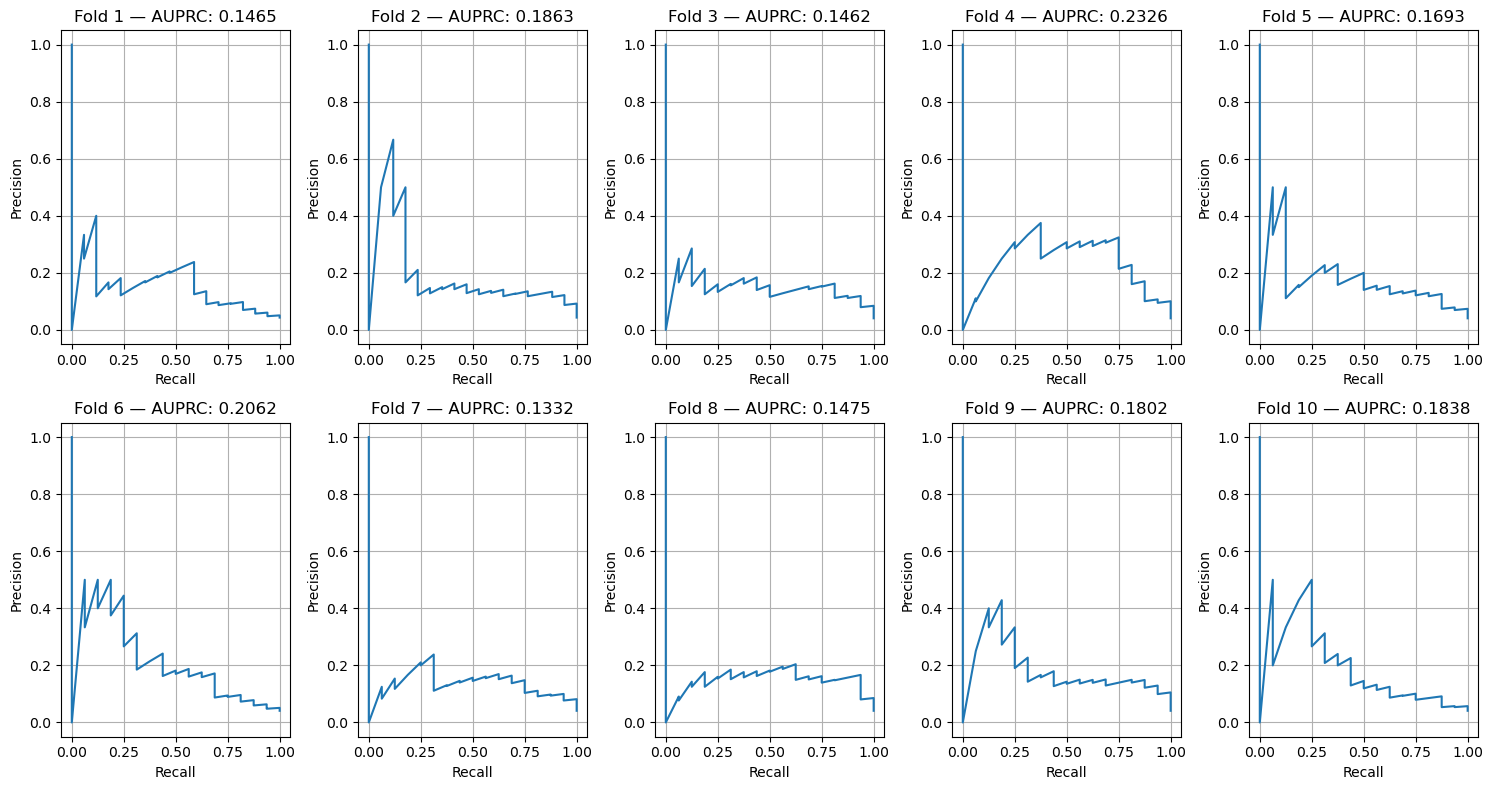


Mean AUPRC across 10 folds: 0.1732


In [15]:
rf_tuning_only = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=200, min_samples_leaf=5, min_samples_split=2, max_depth=5)
rf_tuning_only.fit(X_train, y_train)

mean_auprc, all_scores = evaluate_pr_cross_val(rf_tuning_only, X_train, y_train, 10)

What if we did hyperparameter tuning after feature selection? Will the techniques work together?

In [16]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf_model_after_feature_selection,
    param_grid,
    cv=5,
    scoring='average_precision',
    n_jobs=-1
)

grid_search.fit(X_train_after_feature_selection, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


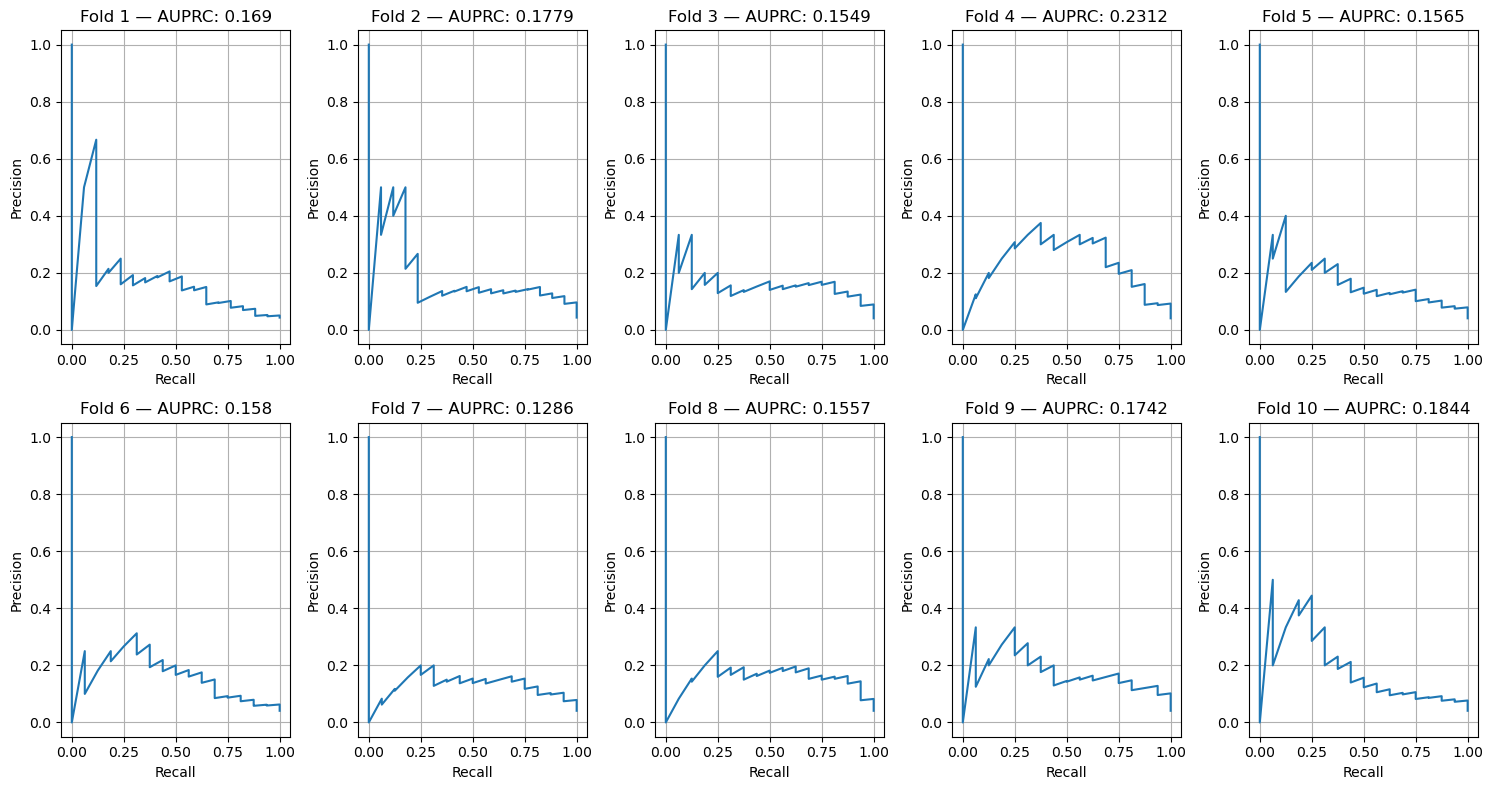


Mean AUPRC across 10 folds: 0.169


In [17]:
rf_tuning_and_selection = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=300, min_samples_leaf=5, min_samples_split=2, max_depth=5)
rf_tuning_and_selection.fit(X_train_after_feature_selection, y_train)

mean_auprc, all_scores = evaluate_pr_cross_val(rf_tuning_and_selection, X_train_after_feature_selection, y_train, 10)

The combination of methods is actually less effective on the training set than just hyperparameter tuning alone, so we will use this version on our test set as the final model.

Area Under Precision-Recall Curve (AUPRC): 0.1963


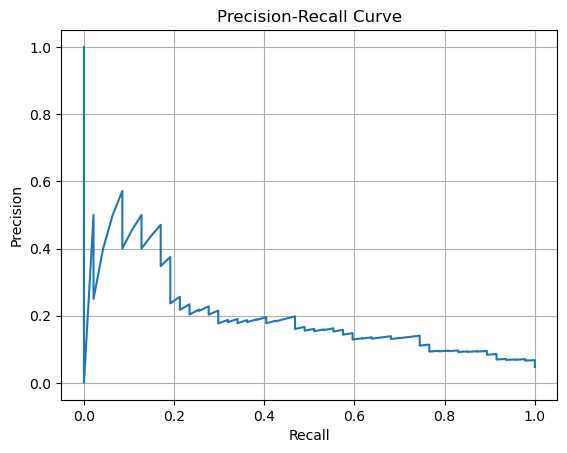

In [18]:
evaluate_pr(rf_tuning_only, X_test, y_test)